**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [73]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import minimize_scalar

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [59]:
# creating symbols
C = sm.symbols('C') 
k = sm.symbols('kappa')
w = sm.symbols('omega')
t = sm.symbols('tau')
G = sm.symbols('G')
v = sm.symbols('nu')
L = sm.symbols('L')
a = sm.symbols('alpha')
w_tilde = sm.symbols('omegatilde')
L_star = sm.symbols('L^*')

In [60]:
# defining the utility function in symbols
utility = sm.log(C**a*G**(1-a))-v*(L**2)/2
utility

-L**2*nu/2 + log(C**alpha*G**(1 - alpha))

In [61]:
# defining the budget constraint as an equality in symbols
consumption_constraint = sm.Eq(k+w_tilde*L,C)
consumption_constraint

Eq(L*omegatilde + kappa, C)

In [62]:
# isolating C in the budget constraint
C_from_constraint = sm.solve(consumption_constraint,C)
C_from_constraint[0]

L*omegatilde + kappa

In [63]:
# substituting C from the constraint into the utility function
utility_subs = utility.subs(C,C_from_constraint[0])
utility_subs

-L**2*nu/2 + log(G**(1 - alpha)*(L*omegatilde + kappa)**alpha)

In [64]:
# calculating the first order condition
foc = sm.diff(utility_subs, L)
foc

G**(1 - alpha)*G**(alpha - 1)*alpha*omegatilde/(L*omegatilde + kappa) - L*nu

In [65]:
# solving for optimal labour supply
sol = sm.solve(sm.Eq(foc,0), L)[1] # we choose the 1. element to get the positive solution
sol_opt = sm.Eq(L_star,sol)
sol_opt

Eq(L^*, (-kappa*nu + sqrt(nu*(4*alpha*omegatilde**2 + kappa**2*nu)))/(2*nu*omegatilde))

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [66]:
# defining w_tilde
w_tilde_eq = (1-t)*w

#substituting the expression for w_tilde into the optimal labour supply
L_star_subs = sol.subs(w_tilde,w_tilde_eq)
L_star_subs_opt = sm.Eq(L_star, L_star_subs)
L_star_subs_opt


Eq(L^*, (-kappa*nu + sqrt(nu*(4*alpha*omega**2*(1 - tau)**2 + kappa**2*nu)))/(2*nu*omega*(1 - tau)))

In [67]:
# we lambdify the labour supply equation
labour_supply_function = sm.lambdify((w,v,k,a,t),L_star_subs)

Text(0.5, 1.0, 'Optimal labour supply')

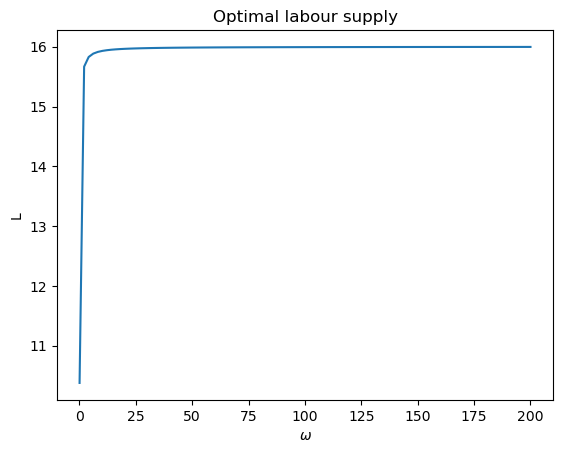

In [68]:
#creating a vector of omega-values
w_vec = np.linspace(0.1,200,100)

# adding value to parameters
a_val = 0.5
k_val = 1
v_val = 1/(2*16**2)
w_val = 1
t_val = 0.3

# find optimal labour supply given a vector of omega-values
labour_supply_vec = labour_supply_function(w_vec,v_val, k_val, a_val, t_val)

# plot optimal labour supply given omega
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,labour_supply_vec)
plt.xlabel(r"$\omega$")
plt.ylabel("L")
plt.title("Optimal labour supply")

We see that optimal labour supply....


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


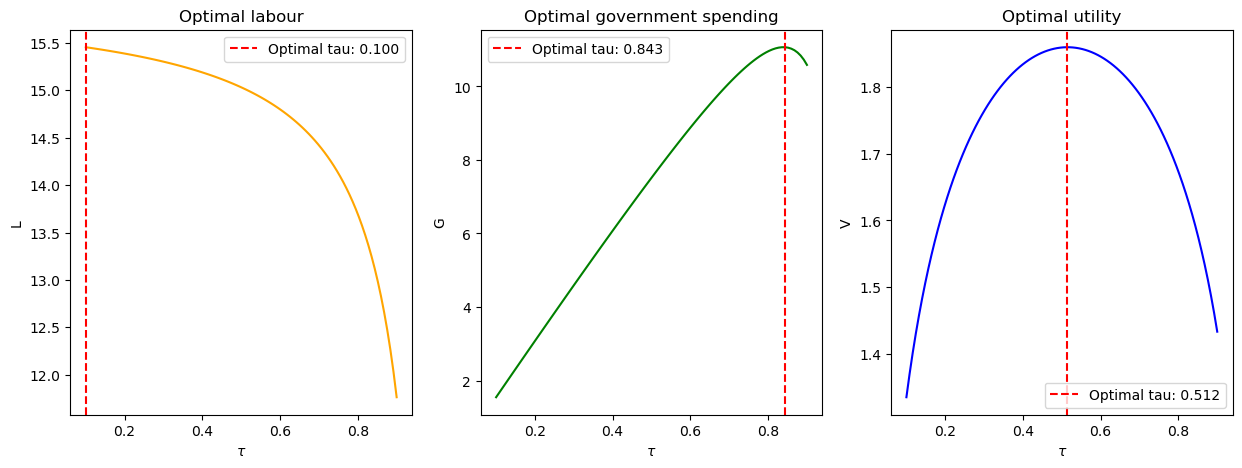

In [78]:
# creating vector of tau-values
t_vec = np.linspace(0.1,0.9,100)

# find optimal labour supply, government spending and utility given tau
optimal_L = labour_supply_function(w_val,v_val, k_val, a_val, t_vec)

optimal_G = t_vec*w_val*optimal_L

optimal_U = np.log((k_val+(1-t_vec)*w_val*optimal_L)**a_val*optimal_G**(1-a_val))-v_val*optimal_L**2/2

# find tau values that maximises labour supply, government spending and utility
opt_L_val = t_vec[np.argmax(optimal_L)]
opt_G_val = t_vec[np.argmax(optimal_G)]
opt_t_val = t_vec[np.argmax(optimal_U)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax.plot(t_vec,optimal_L, c="orange")
plt.xlabel(r"$\tau$")
plt.ylabel("L")
plt.title("Optimal labour")
plt.axvline(x=opt_L_val, color='r', linestyle='--', label=f"Optimal tau: {opt_L_val:.3f}")
plt.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(t_vec,optimal_G, c="green")
plt.xlabel(r"$\tau$")
plt.ylabel("G")
plt.title("Optimal government spending")
plt.axvline(x=opt_G_val, color='r', linestyle='--', label=f"Optimal tau: {opt_G_val:.3f}")
plt.legend()


ax = fig.add_subplot(1,3,3)
ax.plot(t_vec,optimal_U,  c="blue")
plt.xlabel(r"$\tau$")
plt.ylabel("V")
plt.title("Optimal utility")
plt.axvline(x=opt_t_val, color='r', linestyle='--', label=f"Optimal tau: {opt_t_val:.3f}")
plt.legend()


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [90]:
import numpy as np
from scipy import optimize

# Define utility function
def utility_function(tau, L):
    U = np.log((k_val + (1 - tau) * w_val * L)**a_val * (tau*w_val*(labour_supply_function(w_val,v_val, k_val, a_val, tau)))**(1 - a_val)) - v_val * L**2 / 2
    return U

# Define objective function
obj_func = lambda x: -utility_function(x[0], x[1])

# Define bounds
bound = [(0.1, 0.9), (0, 24)]

# Define initial values
x0 = [0.4, 16]

# Call optimizer
result = optimize.minimize(obj_func, x0, method='SLSQP', bounds=bound, options={'disp': True})

# Retrieve optimized values
tau_opt = result.x[0]
L_opt = result.x[1]

print('tau =', tau_opt)
print('L =', L_opt)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.8591992398624537
            Iterations: 12
            Function evaluations: 37
            Gradient evaluations: 12
tau = 0.5145208445856817
L = 15.000769114735492


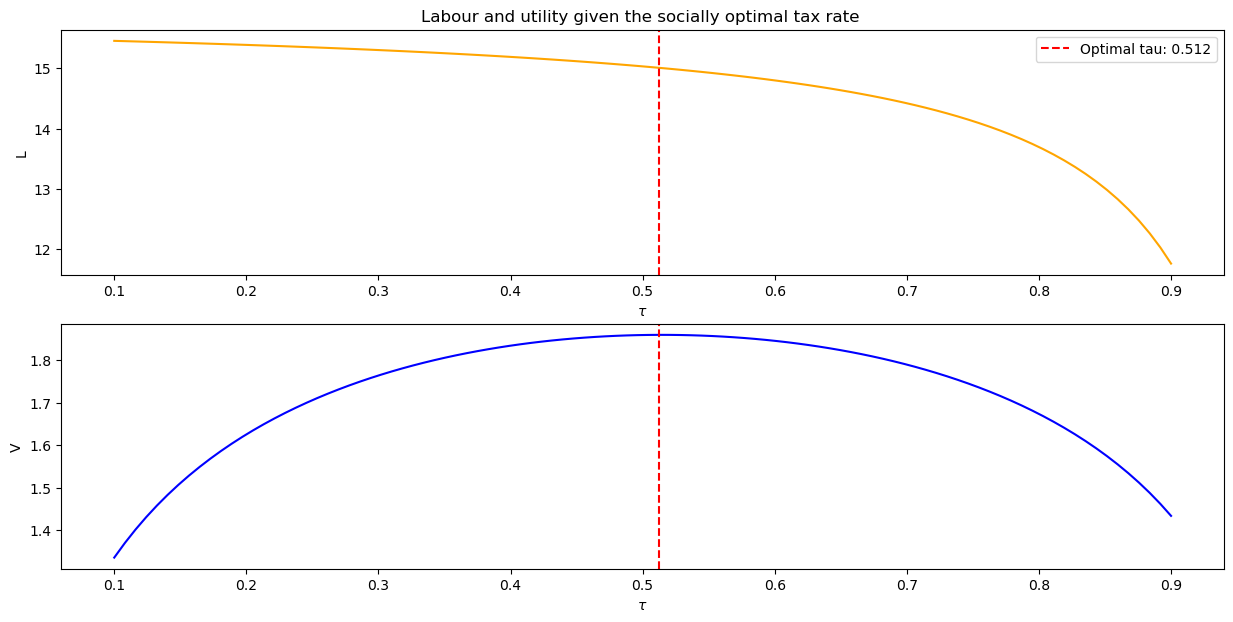

In [120]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(2,1,1)
ax.plot(t_vec,optimal_L, c="orange")
plt.xlabel(r"$\tau$")
plt.ylabel("L")
plt.title("Labour and utility given the socially optimal tax rate ")
plt.axvline(x=opt_t_val, color='r', linestyle='--', label=f"Optimal tau: {opt_t_val:.3f}")
plt.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(t_vec,optimal_U,  c="blue")
plt.xlabel(r"$\tau$")
plt.ylabel("V")
plt.axvline(x=opt_t_val, color='r', linestyle='--', label=f"Optimal tau: {opt_t_val:.3f}")

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [157]:
t_val_opt = tau_opt
t_val_opt
sigma_val = 1.001
rho_val = 1.001
epsilon_val = 1.0

In [159]:
from scipy.optimize import minimize

def objective_function(params, w, tau, G, alpha, kappa, nu, epsilon, sigma, rho):
    L = params[0]
    C = kappa + (1 - tau) * w * L
    value = ((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1)))**(1 - rho)
    utility = value / (1 - rho) - nu * (L**(1 + epsilon)) / (1 + epsilon)
    return -utility  # Negative sign for maximization

# Parameter values
w = 1.0
tau = 0.51
G = 1.0
alpha = 0.5
kappa = 0.0
nu = 1.0
epsilon = 1.0
sigma = 1.001
rho = 1.001

# Define the constraint function
def constraint_function(params, w, tau):
    L = params[0]
    return kappa + (1 - tau) * w * L

# Solve the optimization problem
result = minimize(
    objective_function,
    x0=[0],  # Initial guess for L
    bounds=[(0, 24)],  # Bounds for L
    args=(w, tau, G, alpha, kappa, nu, epsilon, sigma, rho),
    constraints={'type': 'eq', 'fun': constraint_function, 'args': (w, tau)}
)

if result.success:
    optimal_L = result.x[0]
    optimal_V = -result.fun  # Convert back to positive value
    print(f"Optimal L: {optimal_L:.2f}")
    print(f"Optimal V: {optimal_V:.2f}")
else:
    print("Optimization failed. Check the input parameters.")


Optimal L: 0.00
Optimal V: -2001.39


In [121]:
s = sm.symbols('sigma')
rho = sm.symbols('rho')
eps = sm.symbols('epsilon')

In [122]:
# defining the utility function
utility_new = (((a * (k+(1-t)*w*L)**((s - 1) / s) + (1 - a) * G**((s - 1) / s))**(s / (s- 1)))**(1 - rho) - 1) / (1 - rho) - v * L**(1 + eps) / (1 + eps)
utility_new

-L**(epsilon + 1)*nu/(epsilon + 1) + (((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))**(sigma/(sigma - 1)))**(1 - rho) - 1)/(1 - rho)

In [124]:
# defining the budget constraint as an equality
consumption_constraint = sm.Eq(k+(1-t)*w*L,C)
consumption_constraint

Eq(L*omega*(1 - tau) + kappa, C)

In [125]:
# substituting C from the constraint into the utility function
utility_subs_new = utility_new.subs(C,C_from_constraint[0])
utility_subs_new

-L**(epsilon + 1)*nu/(epsilon + 1) + (((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))**(sigma/(sigma - 1)))**(1 - rho) - 1)/(1 - rho)

In [126]:
# calculating the foc
foc_new = sm.diff(utility_subs_new, L)
foc_new

alpha*omega*(1 - tau)*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma)*((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))**(sigma/(sigma - 1)))**(1 - rho)/((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))*(L*omega*(1 - tau) + kappa)) - L**(epsilon + 1)*nu/L

In [128]:
# solving for optimal labour supply
sol_new = sm.solve(sm.Eq(foc_new,0), L)[0]
sol_opt_new = sm.Eq(L_star,sol_new)
sol_opt_new

NotImplementedError: multiple generators [((-G*alpha/G**(1/sigma) + G/G**(1/sigma) - L*alpha*omega*tau/(-L*omega*tau + L*omega + kappa)**(1/sigma) + L*alpha*omega/(-L*omega*tau + L*omega + kappa)**(1/sigma) + alpha*kappa/(-L*omega*tau + L*omega + kappa)**(1/sigma))**(sigma/(sigma - 1)))**(-rho), (-G*alpha/G**(1/sigma) + G/G**(1/sigma) - L*alpha*omega*tau/(-L*omega*tau + L*omega + kappa)**(1/sigma) + L*alpha*omega/(-L*omega*tau + L*omega + kappa)**(1/sigma) + alpha*kappa/(-L*omega*tau + L*omega + kappa)**(1/sigma))**(sigma/(sigma - 1)), (-L*omega*tau + L*omega + kappa)**(-1/sigma), L, L**epsilon]
No algorithms are implemented to solve equation alpha*omega*(1 - tau)*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma)*((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))**(sigma/(sigma - 1)))**(1 - rho)/((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))*(L*omega*(1 - tau) + kappa)) - L**(epsilon + 1)*nu/L

In [129]:
from sympy import symbols, Eq, nsolve

# Define the symbols in the equation
L, G, alpha, sigma, omega, tau, kappa, rho, epsilon, nu = symbols('L G alpha sigma omega tau kappa rho epsilon nu')

# Define the equation
equation = Eq(alpha*omega*(1 - tau)*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma)*((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))**(sigma/(sigma - 1)))**(1 - rho)/((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))*(L*omega*(1 - tau) + kappa)) - L**(epsilon + 1)*nu/L)

# Solve numerically
solution = nsolve(equation, L, 1)  # Assuming an initial guess of L = 1

print(solution)


/var/folders/7l/ds0r5wcs2pz7_scg8504fft00000gn/T/ipykernel_96771/164656282.py:7: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  equation = Eq(alpha*omega*(1 - tau)*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma)*((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))**(sigma/(sigma - 1)))**(1 - rho)/((G**((sigma - 1)/sigma)*(1 - alpha) + alpha*(L*omega*(1 - tau) + kappa)**((sigma - 1)/sigma))*(L*omega*(1 - tau) + kappa)) - L**(epsilon + 1)*nu/L)


ValueError: 
expected a one-dimensional and numerical function

In [99]:
# Define utility function
def utility_function(L, G):
    U = (((a_val * (k_val+(1-t_val_opt)*w_val*L)**((sigma_val - 1) / sigma_val) + (1 - a_val) * G**((sigma_val - 1) / sigma_val))**(sigma_val / (sigma_val - 1)))**(1 - rho_val) - 1) / (1 - rho_val) - v_val * L**(1 + epsilon_val) / (1 + epsilon_val)
    return U

# Define objective function
obj_func_2 = lambda x: -utility_function(x[0], x[1])

# Define bounds
bound = [(0, 24),(1,3)]

# Define initial values
x0_2 = [16, 1.5]

# Call optimizer
result = optimize.minimize(obj_func_2, x0_2, method='SLSQP', bounds=bound, options={'disp': True})

# Retrieve optimized values
L_opt = result.x[0]
G_opt = result.x[1]

print('L =', L_opt)
print('G =', G_opt)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3854722537021904
            Iterations: 8
            Function evaluations: 25
            Gradient evaluations: 8
L = 14.99416357087824
G = 3.0


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [35]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$
Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [36]:
# defining parameters
kappa = sm.symbols('kappa_t') 
n = sm.symbols('eta')
l = sm.symbols('l_t')
w = sm.symbols('omega')
l_star = sm.symbols('l^*')

# defining profit function
pi = kappa*l**(1-n)-w*l

# calculating foc
foc = sm.diff(pi, l)

# maximising profit
sol = sm.solve(sm.Eq(foc,0), l)[0]
sol_opt = sm.Eq(l_star,sol)
sol_opt

Eq(l^*, (kappa_t*(1 - eta)/omega)**(1/eta))

Showing it numerically

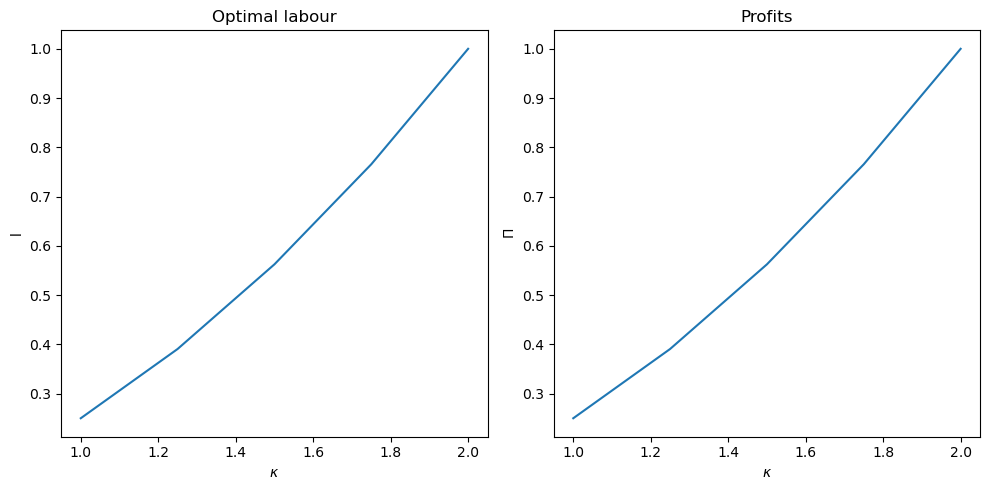

In [147]:
eta = 0.5
w = 1.0
kappa_values = np.linspace(1,2,5)

def find_optimal_l_and_pi(eta, w, kappa_values):
    optimal_l_values = []
    profits = []
    
    for kappa in kappa_values:
        optimal_l = ((1 - eta) * kappa / w) ** (1 / eta)
        optimal_l_values.append(optimal_l)

    for i, kappa in enumerate(kappa_values):
        profit = calculate_profit(eta, w, kappa, optimal_l_values[i])
        profits.append(profit)

    return optimal_l_values, profits

# Plot optimal l
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
plt.plot(kappa_values, optimal_l_values)
plt.xlabel(r'$\kappa$')
plt.ylabel('l')
plt.title('Optimal labour')

# Plot profits
ax = fig.add_subplot(1,2,2)
plt.plot(kappa_values, profits)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\Pi$')
plt.title('Profits')

plt.tight_layout()
plt.show()

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$

The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.

Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [148]:
# define the parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
eta = 0.5
w = 1.0
K = 10000  # Number of shock series for approximation

# generating K random shock series
np.random.seed(2023)  # setting a seed for reproducibility
epsilon_list = np.random.normal(loc=-0.5 * sigma_epsilon ** 2, scale=sigma_epsilon, size=(K, 120))

# function to calculate h(epsilon_0, epsilon_1, ..., epsilon_119)
def calculate_h(epsilon):
    kappa_t_minus_1 = 1  # Initial demand shock
    l_t_minus_1 = 0  # Initial number of employees
    h_value = 0  # Accumulator for h function

    for t in range(120):
        epsilon_t = epsilon[t]
        log_kappa_t = rho * np.log(kappa_t_minus_1) + epsilon_t
        kappa_t = np.exp(log_kappa_t)

        # calculate l_t
        l_t = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # calculate the h function value for this period
        h_value += R ** (-t) * (kappa_t * l_t ** (1 - eta) - w * l_t - (l_t != l_t_minus_1) * iota)

        # update the variables for the next period
        kappa_t_minus_1 = kappa_t
        l_t_minus_1 = l_t

    return h_value

# calculating the ex ante expected value of the salon
H = np.mean([calculate_h(epsilon) for epsilon in epsilon_list])
print("Expected value of the salon (H) =", H)


Expected value of the salon (H) = 27.75319379491799


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [134]:
# defining parameter
delta = 0.05

# function to calculate h(epsilon_0, epsilon_1, ..., epsilon_119)
def calculate_h_delta(epsilon, delta):
    kappa_t_minus_1 = 1  # Initial demand shock
    l_t_minus_1 = 0  # Initial number of employees
    h_value = 0  # Accumulator for h function

    for t in range(120):
        epsilon_t = epsilon[t]
        log_kappa_t = rho * np.log(kappa_t_minus_1) + epsilon_t
        kappa_t = np.exp(log_kappa_t)

        # calculating l_t b
        l_t_star = ((1 - eta) * kappa_t / w) ** (1 / eta)

        # implementing policy
        if np.abs(l_t_minus_1 - l_t_star) > delta:
            l_t = l_t_star
        else:
            l_t = l_t_minus_1

        # calculating the h function value for this period
        h_value += R ** (-t) * (kappa_t * l_t ** (1 - eta) - w * l_t - (l_t != l_t_minus_1) * iota)

        # updating the variables for the next period
        kappa_t_minus_1 = kappa_t
        l_t_minus_1 = l_t

    return h_value

# calculating the ex ante expected value of the salon
H = np.mean([calculate_h_delta(epsilon, delta) for epsilon in epsilon_list])
print("Expected value of the salon (H) with the policy =", H)


Expected value of the salon (H) with the policy = 28.43388844189881


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [149]:
# defining parameter vector
delta_vec = np.linspace(0.01, 0.5, 10)

# calculating H for each delta value
H_vec = []
for delta in delta_vec:
    H = np.mean([calculate_h_delta(epsilon, delta) for epsilon in epsilon_list])
    H_vec.append(H)

# finding the optimal delta value
optimal_delta = delta_vec[np.argmax(H_vec)]
max_H = np.max(H_vec)


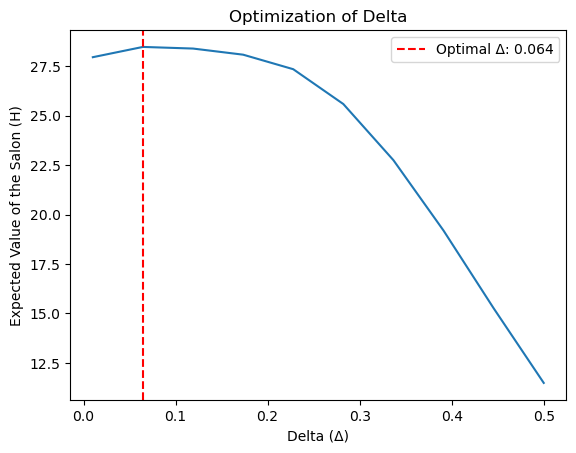

Optimal Delta (Δ): 0.06444444444444444
Maximum Expected Value of the Salon (H): 28.480739651741715


In [ ]:
# plotting the results
plt.plot(delta_vec, H_vec)
plt.xlabel("Delta (Δ)")
plt.ylabel("Expected Value of the Salon (H)")
plt.title("Optimization of Delta")
plt.axvline(x=optimal_delta, color='r', linestyle='--', label=f"Optimal Δ: {optimal_delta:.3f}")
plt.legend()
plt.show()

print("Optimal Delta (Δ):", optimal_delta)
print("Maximum Expected Value of the Salon (H):", max_H)


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [167]:
# function to calculate h(epsilon_0, epsilon_1, ..., epsilon_119)
def calculate_h_iota(epsilon, iota):
    kappa_t_minus_1 = 1  # Initial demand shock
    l_t_minus_1 = 0  # Initial number of employees
    h_value = 0  # Accumulator for h function

    for t in range(120):
        epsilon_t = epsilon[t]
        log_kappa_t = rho * np.log(kappa_t_minus_1) + epsilon_t
        kappa_t = np.exp(log_kappa_t)

        # Calculate l_t based on the policy
        l_t = ((1 - eta) * kappa_t / w) ** (1 / eta)

        if kappa_t >= 0:
            iota = 0.01*kappa_t**0.5
        else:
            iota = 0.01*-kappa_t

        # Calculate the h function value for this period
        h_value += R ** (-t) * (kappa_t * l_t ** (1 - eta) - w * l_t - (l_t != l_t_minus_1) * iota)

        # Update the variables for the next period
        kappa_t_minus_1 = kappa_t
        l_t_minus_1 = l_t

    return h_value

H = np.mean([calculate_h_iota(epsilon, iota) for epsilon in epsilon_list])
print("Expected value of the salon (H) with the policy =", H)


Expected value of the salon (H) with the policy = 66.61464253753715


Forklaring: Det er dyrere at fyre end at hyre

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [44]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.
As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

The optimal solution is: [-7.66892986e-09 -3.04614403e-10]
And the objective value is: 0.0


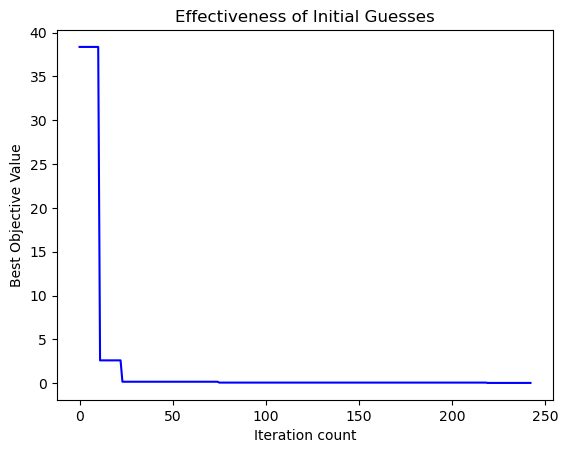

In [155]:
# defining the refined global optimizer with multi-start
def multi_start():

    # step 1
    x_min, x_max = [-600,600] # bounds
    tau = 1e-8 # tolerance

    # step 2
    K_warm = 10 # warm-up iterations
    K = 1000 # maximum nb. of iterations

    # step 3
    # A
    x_opt = np.random.uniform(x_min, x_max, size=2) # initial best solution
    f_opt = griewank(x_opt) # function evaluated at best solution
    f_opt_store1 = [f_opt]  # storing best solutions

    for k in range(K):
        x = np.random.uniform(x_min, x_max, size=2) # generate random solution

        # B
        if k >= K_warm:
            # C: calculate chi
            Chi_k = 0.50 * 2 / (1 + np.exp((k - K_warm) / 100)) 
            # D: refine initial guess
            x_k0 = Chi_k * x + (1 - Chi_k) * x_opt 

            # E: optimize with x_k0 as initial guess
            result = optimize.minimize(griewank, x_k0, method='BFGS', tol=tau)
            x_k_star = result.x # optimized solution

            # F: updating best solution (x_opt) if necessary
            f_k_star = griewank(x_k_star)
            if f_k_star < f_opt:
                x_opt = x_k_star
                f_opt = f_k_star

            # G: check tolerance
            if f_opt < tau:
                break

        f_opt_store1.append(f_opt)  # storing best objective for each iteration

    # step 4 
    return x_opt, f_opt_store1 # return result and stored history

#printing results
result, f_opt_store1 = multi_start()
print("The optimal solution is:", result)
print("And the objective value is:", griewank(result))

# plotting the best objective value as a function of iteration counter
iterations = range(len(f_opt_store1))
plt.plot(iterations, f_opt_store1, c='blue')
plt.xlabel("Iteration count")
plt.ylabel("Best Objective Value")
plt.title("Effectiveness of Initial Guesses")
plt.show()

Implementing the refined global optimizer with multistart indicates that the best objective value is zero after about 25 iterations. 

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

The optimal solution is: [-6.64505865e-09 -2.48791799e-08]
And the objective value is: 1.1102230246251565e-16


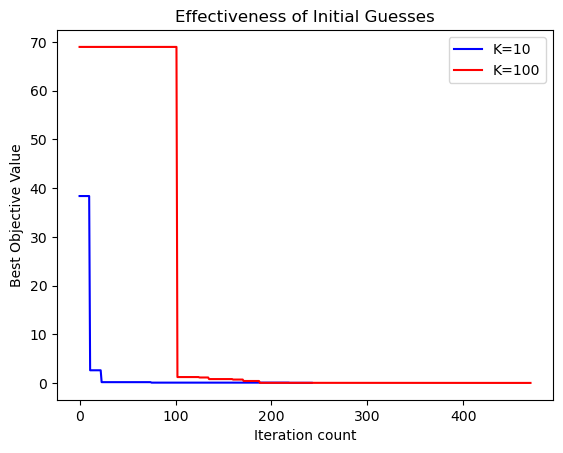

In [156]:
def multi_start():

    # step 1
    x_min, x_max = [-600,600] # bounds
    tau = 1e-8 # tolerance

    # step 2
    K_warm = 100 # warm-up iterations
    K = 1000 # maximum nb. of iterations

    # step 3
    # A
    x_opt = np.random.uniform(x_min, x_max, size=2) # initial best solution
    f_opt = griewank(x_opt) # function evaluated at best solution
    f_opt_store2 = [f_opt]  # storing best solutions

    for k in range(K):
        x = np.random.uniform(x_min, x_max, size=2) # generate solution

        # B
        if k >= K_warm:
            # C: calculate chi
            Chi_k = 0.50 * 2 / (1 + np.exp((k - K_warm) / 100))
            # D: refine initial guess
            x_k0 = Chi_k * x + (1 - Chi_k) * x_opt

            # E: optimize with x_k0 as initial guess
            result = optimize.minimize(griewank, x_k0, method='BFGS', tol=tau)
            x_k_star = result.x # optimized solution

            # F: updating best solution (x_opt) if necessary
            f_k_star = griewank(x_k_star)
            if f_k_star < f_opt:
                x_opt = x_k_star
                f_opt = f_k_star

            # G: check tolerance
            if f_opt < tau:
                break

        f_opt_store2.append(f_opt)  # storing best objective for each iteration

    # step 4 
    return x_opt, f_opt_store2 # return result and stored history

#printing solution
result, f_opt_store2 = multi_start()
print("The optimal solution is:", result)
print("And the objective value is:", griewank(result))

# plotting the best objective value as a function of iteration counter
iterations1 = range(len(f_opt_store1))
iterations2 = range(len(f_opt_store2))

plt.plot(iterations1, f_opt_store1, c='blue', label='K=10')
plt.plot(iterations2, f_opt_store2, c='red', label='K=100')

plt.xlabel("Iteration count")
plt.ylabel("Best Objective Value")
plt.title("Effectiveness of Initial Guesses")
plt.legend()
plt.show()

We see that setting a higher value of $\underline{K}$ makes the convergense slower compared to the first case where $\underline{K} = 10$. This might be due to...